<a href="https://colab.research.google.com/github/Kuizinass/AI-Projects/blob/main/03_Convolutional_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.15.0


## Introduction to Convolutional Neural Networks and Computer Vision with TensorFlow

Computer vision is the practise of writing algorythms which can discover patterns in video such as recognizing a car in front

## Get the data

In [ ]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("pizza_steak.zip")
zip_ref.extractall()
zip_ref.close()

--2024-06-20 08:54:37--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.207, 74.125.195.207, 172.253.117.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip.1’

pizza_steak.zip.1   100%[===================>] 104.47M   210MB/s    in 0.5s    

2024-06-20 08:54:37 (210 MB/s) - ‘pizza_steak.zip.1’ saved [109540975/109540975]



## Inspect the data

A very crucial step at the beggining of every machine learning project is becoming one with the data

And for computer vision project... this usually means visualizing the data

In [ ]:
!ls pizza_steak

test  train


In [ ]:
!ls pizza_steak/train

pizza  steak


In [ ]:
!ls pizza_steak/train/steak

1000205.jpg  1598345.jpg  2062248.jpg  2548974.jpg  3030578.jpg  3571963.jpg  510757.jpg
100135.jpg   1598885.jpg  2081995.jpg  2549316.jpg  3047807.jpg  3576078.jpg  513129.jpg
101312.jpg   1600179.jpg  2087958.jpg  2561199.jpg  3059843.jpg  3577618.jpg  513842.jpg
1021458.jpg  1600794.jpg  2088030.jpg  2563233.jpg  3074367.jpg  3577732.jpg  523535.jpg
1032846.jpg  160552.jpg   2088195.jpg  256592.jpg   3082120.jpg  3578934.jpg  525041.jpg
10380.jpg    1606596.jpg  2090493.jpg  2568848.jpg  3094354.jpg  358042.jpg   534560.jpg
1049459.jpg  1615395.jpg  2090504.jpg  2573392.jpg  3095301.jpg  358045.jpg   534633.jpg
1053665.jpg  1618011.jpg  2125877.jpg  2592401.jpg  3099645.jpg  3591821.jpg  536535.jpg
1068516.jpg  1619357.jpg  2129685.jpg  2599817.jpg  3100476.jpg  359330.jpg   541410.jpg
1068975.jpg  1621763.jpg  2133717.jpg  2603058.jpg  3110387.jpg  3601483.jpg  543691.jpg
1081258.jpg  1623325.jpg  2136662.jpg  2606444.jpg  3113772.jpg  3606642.jpg  560503.jpg
1090122.jpg  1624450.

In [ ]:
import os

# Walk through the pizza_steak directory and list number of files
for dirpath, dirnames, filenames in os.walk("pizza_steak"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


There are 2 directories and 0 images in 'pizza_steak'.
There are 2 directories and 0 images in 'pizza_steak/train'.
There are 0 directories and 750 images in 'pizza_steak/train/steak'.
There are 0 directories and 750 images in 'pizza_steak/train/pizza'.
There are 2 directories and 0 images in 'pizza_steak/test'.
There are 0 directories and 250 images in 'pizza_steak/test/steak'.
There are 0 directories and 250 images in 'pizza_steak/test/pizza'.


In [ ]:
# Another way to find out how many images are in a file
num_stake_images_train = len(os.listdir("pizza_steak/train/steak"))

num_stake_images_train

750

## To visualize our images, let's class names programmatically

In [ ]:
# Get the classnames programmatically
import pathlib
import numpy as np
data_dir = pathlib.Path("pizza_steak/train")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")])) # Create a list of class_names from the subdirectories
print(class_names)

['pizza' 'steak']


In [ ]:
# Let's visualize our images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup the target directory
  target_folder = target_dir+target_class

  # Get random image
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read the image and plot it using mathplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # Show the shape of the image

  return img

Image shape: (512, 512, 3)


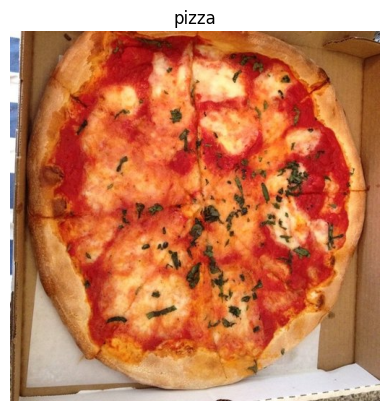

In [ ]:
# View a random image from the training dataset
img = view_random_image(target_dir="pizza_steak/train/",
                        target_class="pizza")

## Let's build an end-to-end example

Let's build a convolutional neural network to find patterns in our images more specifically we need:

* Load our images
* Preproces our images
* Build CNN to find patterns
* Compile our CNN
* Fit the CNN


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the seed
tf.random.set_seed(42)

# Preprocess data (get all the pixel values between 0 & 1)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Set up path to our directories
train_dir = "pizza_steak/train"
test_dir = "pizza_steak/test"

# Import data from the directories and turn it into batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                            batch_size=32,
                                            target_size=(224, 224),
                                            class_mode="binary",
                                            seed=42)
valid_data = valid_datagen.flow_from_directory(directory=test_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42)

# Build a CNN model
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=3,
                           activation="relu",
                           input_shape=(224, 224, 3)),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2,
                              padding="valid"),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the CNN
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/5
47/47 [==============================] - 14s 172ms/step - loss: 0.6316 - accuracy: 0.6413 - val_loss: 0.5004 - val_accuracy: 0.7560
Epoch 2/5
47/47 [==============================] - 5s 111ms/step - loss: 0.4774 - accuracy: 0.7860 - val_loss: 0.3687 - val_accuracy: 0.8320
Epoch 3/5
47/47 [==============================] - 6s 133ms/step - loss: 0.4264 - accuracy: 0.8073 - val_loss: 0.3726 - val_accuracy: 0.8620
Epoch 4/5
47/47 [==============================] - 7s 147ms/step - loss: 0.3812 - accuracy: 0.8367 - val_loss: 0.3123 - val_accuracy: 0.8720
Epoch 5/5
47/47 [==============================] - 5s 112ms/step - loss: 0.3283 - accuracy: 0.8653 - val_loss: 0.3000 - val_accuracy: 0.8660


## As we can see below using CPU it takes 100 seconds per epoch, changing to GPU it reduces time to 8-10 seconds
# Epoch 1/5
# 47/47 [==============================] - 101s 2s/step - loss: 0.5700 - accuracy: 0.7173 - val_loss: 0.4278 - val_accuracy: 0.8320

In [ ]:
# Let's explore model summary
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 conv2d_4 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 110, 110, 10)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_6 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 53, 53, 10)        0         
 g2D)                                                 

## Using the same model as before

In [ ]:
# Set random seed
tf.random.set_seed(42)

# Create a model to replicate the TensorFlow Playground model
model_2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(224, 224, 3)),
    tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_2 = model_2.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/5
47/47 [==============================] - 8s 138ms/step - loss: 0.8431 - accuracy: 0.4993 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/5
47/47 [==============================] - 5s 103ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/5
47/47 [==============================] - 6s 137ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/5
47/47 [==============================] - 5s 104ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/5
47/47 [==============================] - 5s 105ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000


In [ ]:
# Get a summary of model_2
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 150528)            0         
                                                                 
 dense_2 (Dense)             (None, 4)                 602116    
                                                                 
 dense_3 (Dense)             (None, 4)                 20        
                                                                 
 dense_4 (Dense)             (None, 1)                 5         
                                                                 
Total params: 602141 (2.30 MB)
Trainable params: 602141 (2.30 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Despite having 20x parameters model_2 is much worse then our model_1 CNN model

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# Create a model
model_3 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(224, 224, 3)),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_3 = model_3.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/5
47/47 [==============================] - 6s 107ms/step - loss: 3.7550 - accuracy: 0.6320 - val_loss: 1.4915 - val_accuracy: 0.7160
Epoch 2/5
47/47 [==============================] - 6s 125ms/step - loss: 2.0115 - accuracy: 0.6573 - val_loss: 0.6383 - val_accuracy: 0.7760
Epoch 3/5
47/47 [==============================] - 5s 106ms/step - loss: 0.9105 - accuracy: 0.7207 - val_loss: 0.6896 - val_accuracy: 0.7160
Epoch 4/5
47/47 [==============================] - 6s 118ms/step - loss: 0.7762 - accuracy: 0.7207 - val_loss: 0.8412 - val_accuracy: 0.6080
Epoch 5/5
47/47 [==============================] - 5s 112ms/step - loss: 0.5011 - accuracy: 0.7893 - val_loss: 0.4586 - val_accuracy: 0.7700


In [ ]:
# Get a summary of model_3
model_3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 150528)            0         
                                                                 
 dense_5 (Dense)             (None, 100)               15052900  
                                                                 
 dense_6 (Dense)             (None, 100)               10100     
                                                                 
 dense_7 (Dense)             (None, 100)               10100     
                                                                 
 dense_8 (Dense)             (None, 1)                 101       
                                                                 
Total params: 15073201 (57.50 MB)
Trainable params: 15073201 (57.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Binary classification: Let's break it down

1. become one with the data
2. Preprocess the data (prepared for our model, the main step here was scalling/normalizing)
3. Created a model
4. Fit the model
5. Evaluate the model
6. Adjust different parameters and improve the model
7. Repeat until satisfied

### 1. Become one with the data

Image shape: (512, 512, 3)
Image shape: (512, 512, 3)


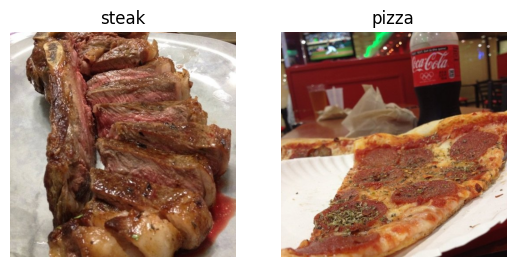

In [ ]:
# Visualize data
plt.figure()
plt.subplot(1, 2, 1)
steak_img = view_random_image("pizza_steak/train/", "steak")
plt.subplot(1, 2 , 2)
pizza_img = view_random_image("pizza_steak/train/", "pizza")

## 2. Preproces the data (prepare it for our model)

In [ ]:
# Define directory dataset path
train_dir = "pizza_steak/train/"
test_dir = "pizza_steak/test/"

## Our next step is to turn our data in **batches**

A batch is a small subset of data. Rather than look at all 10K images we can split into batches of 32

It does this for a couple of reasons:
1. 10,000 images might not fit into the memory at once
2. Trying to learn the patterns in 10,000 images at once might prevent model at learning well

Why 32?

Because 32 is good for your health...

In [ ]:
# Create train and test data generators and rescale the data
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1/255.0)
test_datagen = ImageDataGenerator(rescale=1/255.0)

In [ ]:
# Load in our image data from directories and turn them into batches
train_data = train_datagen.flow_from_directory(directory=train_dir, # Target directory of images
                                               target_size=(224, 224), # Target image size (height, width)
                                               class_mode="binary", # Type of data you are working with
                                               batch_size=32) # Batch size
test_data= test_datagen.flow_from_directory(directory=test_dir,
                                            target_size=(224, 224),
                                            class_mode="binary",
                                            batch_size=32)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [ ]:
# Get sample of our train dataset batch
images, labels = train_data.next() # Get the next batch of images/labels in train data
len(images), len(labels)

(32, 32)

In [ ]:
# How many batches are there
len(train_data)

47

In [ ]:
# Get the first 2 images
images[:2], images[0].shape

(array([[[[0.47058827, 0.40784317, 0.34509805],
          [0.48627454, 0.42352945, 0.36078432],
          [0.48627454, 0.43529415, 0.37254903],
          ...,
          [0.82745105, 0.7137255 , 0.48627454],
          [0.8431373 , 0.7372549 , 0.5294118 ],
          [0.87843144, 0.77647066, 0.58431375]],
 
         [[0.50980395, 0.427451  , 0.36078432],
          [0.5058824 , 0.42352945, 0.35686275],
          [0.5137255 , 0.4431373 , 0.3647059 ],
          ...,
          [0.82745105, 0.7058824 , 0.48235297],
          [0.82745105, 0.70980394, 0.49803925],
          [0.8431373 , 0.73333335, 0.5372549 ]],
 
         [[0.5254902 , 0.427451  , 0.34901962],
          [0.5372549 , 0.43921572, 0.36078432],
          [0.5372549 , 0.45098042, 0.36078432],
          ...,
          [0.82745105, 0.7019608 , 0.4784314 ],
          [0.82745105, 0.7058824 , 0.4901961 ],
          [0.8352942 , 0.7176471 , 0.5137255 ]],
 
         ...,
 
         [[0.77647066, 0.5647059 , 0.2901961 ],
          [0.77647

In [ ]:
images[7].shape

(224, 224, 3)

In [ ]:
# Viewe the first batch of labels
labels

array([1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1.],
      dtype=float32)

## 3. Create a CNN model (start with a baseline)

a baseline is relatively simple model or exisiting result that you steup when beginning a machine learning experimenting

In [ ]:
# Let's make creating our model a little easier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential

In [ ]:
# Create the model
model_4 = Sequential([
    Conv2D(filters=10,
           kernel_size=3,
           strides=1,
           padding="valid",
           activation="relu",
           input_shape=(224, 224, 3)), # input layer (specify input shape)
    Conv2D(10, 3, activation="relu"),
    Conv2D(10, 3, activation="relu"),
    Flatten(),
    Dense(1, activation="sigmoid") # output layer working with binary classification therefore only 1 layer
])

In [ ]:
# Compile the model
model_4.compile(loss="binary_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])

In [ ]:
# Get a summary of our model
model_4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 conv2d_8 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 conv2d_9 (Conv2D)           (None, 218, 218, 10)      910       
                                                                 
 flatten_4 (Flatten)         (None, 475240)            0         
                                                                 
 dense_9 (Dense)             (None, 1)                 475241    
                                                                 
Total params: 477341 (1.82 MB)
Trainable params: 477341 (1.82 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


##  4.Fit the model


In [ ]:
# Check the lenghts of training data and test data generators
len(train_data), len(test_data)

(47, 16)

In [ ]:
#Fit the model
history_4 = model_4.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 9s 146ms/step - loss: 0.8173 - accuracy: 0.6760 - val_loss: 0.4651 - val_accuracy: 0.8000
Epoch 2/5
47/47 [==============================] - 5s 114ms/step - loss: 0.4737 - accuracy: 0.7700 - val_loss: 0.4293 - val_accuracy: 0.7980
Epoch 3/5
47/47 [==============================] - 5s 115ms/step - loss: 0.3410 - accuracy: 0.8653 - val_loss: 0.3338 - val_accuracy: 0.8560
Epoch 4/5
47/47 [==============================] - 5s 116ms/step - loss: 0.1908 - accuracy: 0.9407 - val_loss: 0.3551 - val_accuracy: 0.8360
Epoch 5/5
47/47 [==============================] - 7s 149ms/step - loss: 0.0985 - accuracy: 0.9753 - val_loss: 0.3479 - val_accuracy: 0.8560


## 5. Evaluate our model

It looks like our model is learning something, let's evaluate it

<Axes: >

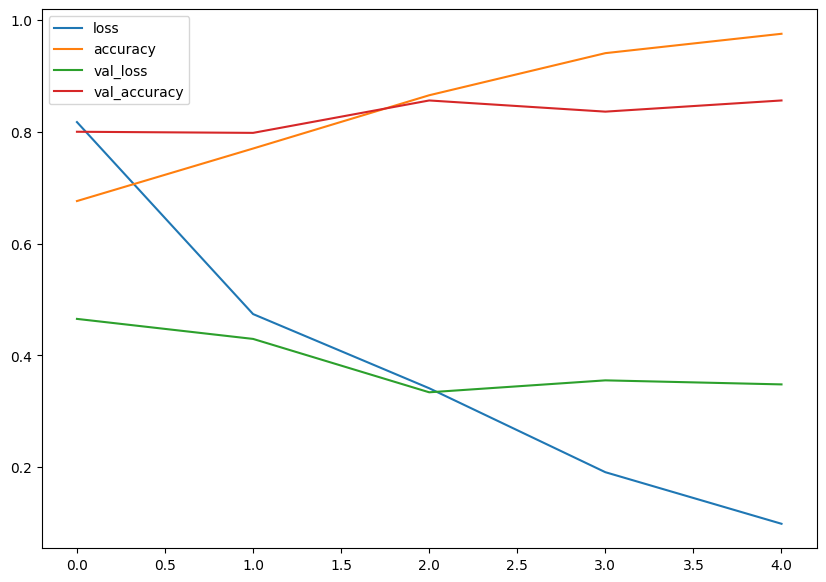

In [ ]:
# Let's plot the loss curve
import pandas as pd
pd.DataFrame(history_4.history).plot(figsize=(10, 7))

In [ ]:
# Plot the validation and training curves separately
def plot_loss_curve(history):
  """
  Returns separate loss curves for training and validation metrics
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"])) # how many epochs we used

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  # PLot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend();

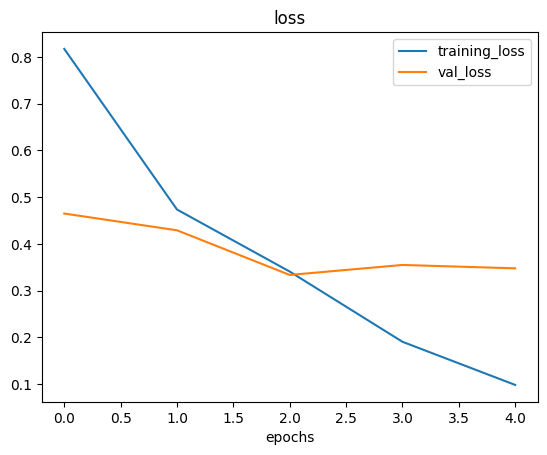

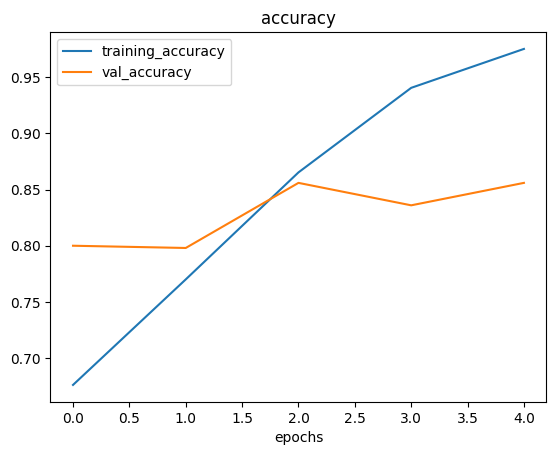

In [ ]:
# Check out the loss and accuracy of model_4
plot_loss_curve(history_4)

## 6. Adjust the model parameters

Fitting a machine learning model comes in 3 steps:

0. Create a Baseline
1. Beat the baseline by overifitting a larger model
2. Reduce overfitting  

Ways to induce overfitting:

* Increase number of conv layers
* Increate the number of conv filters
* Add another dense layer to output of our flattened layer

Reduce overfitting:

* Add data augmentation
* Add regulazation layers
* Add more data

In [ ]:
# Create the model
model_5 = Sequential([
    Conv2D(10, 3, activation="relu", input_shape=(224, 224, 3)),
    MaxPool2D(pool_size=2),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation="sigmoid")
])

In [ ]:
# Compile the model
model_5.compile(loss="binary_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit the model
history_5 = model_5.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(valid_data))

Epoch 1/5
47/47 [==============================] - 9s 146ms/step - loss: 0.6456 - accuracy: 0.6060 - val_loss: 0.5335 - val_accuracy: 0.7680
Epoch 2/5
47/47 [==============================] - 7s 158ms/step - loss: 0.4939 - accuracy: 0.7713 - val_loss: 0.3961 - val_accuracy: 0.8380
Epoch 3/5
47/47 [==============================] - 7s 155ms/step - loss: 0.4300 - accuracy: 0.8100 - val_loss: 0.3801 - val_accuracy: 0.8400
Epoch 4/5
47/47 [==============================] - 7s 142ms/step - loss: 0.3946 - accuracy: 0.8347 - val_loss: 0.3208 - val_accuracy: 0.8820
Epoch 5/5
47/47 [==============================] - 6s 131ms/step - loss: 0.3739 - accuracy: 0.8367 - val_loss: 0.3157 - val_accuracy: 0.8680


In [ ]:
# Let's look at the summary of model_5
model_5.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 111, 111, 10)      0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 54, 54, 10)        0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 52, 52, 10)        910       
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 26, 26, 10)       

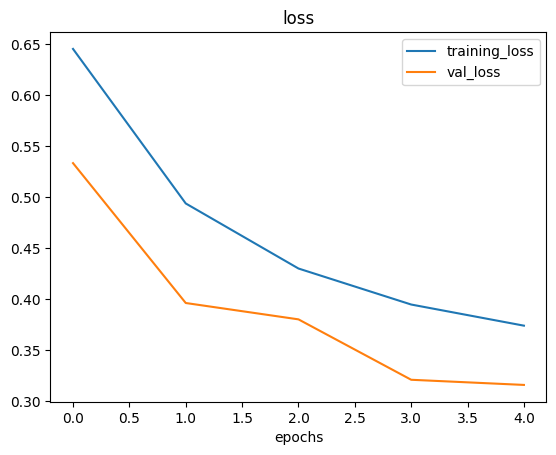

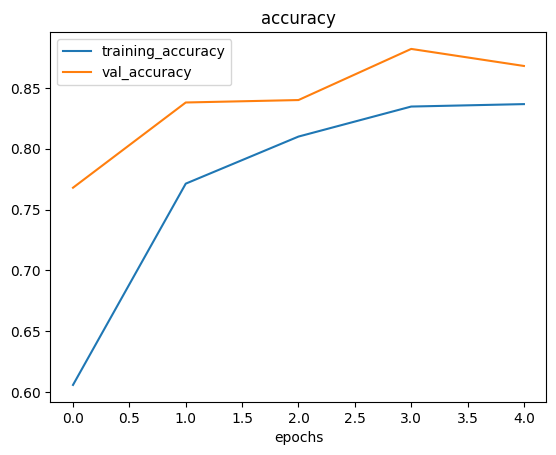

In [ ]:
# Plot loss curves
plot_loss_curve(history_5)

### Opening our bag of tricks and finding data augmentation

In [ ]:
# Create ImageDataGenerator training instance with data augmentation
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=0.2,
                                             shear_range=0.2,
                                             zoom_range=0.2,
                                             width_shift_range=0.2,
                                             height_shift_range=0.3,
                                             horizontal_flip=True)

# Create ImageDataGenerator without data augmentation
train_datagen = ImageDataGenerator(rescale=1/255.)

# Create ImageDataGenerator without data augmentation for the test dataset
test_datagen = ImageDataGenerator(rescale=1/255.)

In [ ]:
# Import data and augment from training directory
print("Augmented training data: ")
train_data_augemented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                    target_size=(224, 224),
                                                                    batch_size=32,
                                                                    class_mode="binary",
                                                                    shuffle=False)

# Create non-augmented train data batches
print("Non-Augmented training data: ")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode="binary",
                                               shuffle=False)

IMG_SIZE = (224, 224)
# Create non_augmented test data batches
print("Non-Augmented test data: ")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMG_SIZE,
                                             batch_size=32,
                                             class_mode="binary")

Augmented training data: 
Found 1500 images belonging to 2 classes.
Non-Augmented training data: 
Found 1500 images belonging to 2 classes.
Non-Augmented test data: 
Found 500 images belonging to 2 classes.


In [ ]:
# Get sample data batches
images, labels = train_data.next()
augmented_images, augmented_labels = train_data_augemented.next()

showing image number: 26


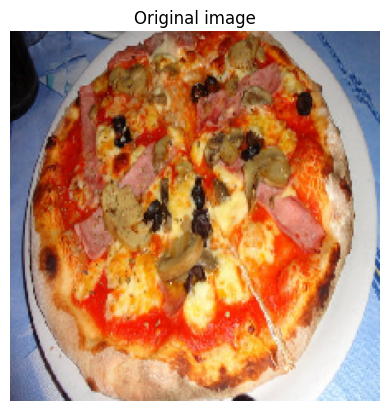

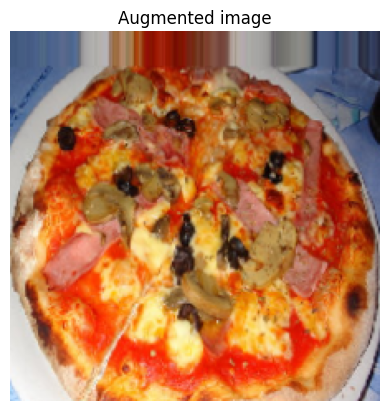

In [ ]:
# Show the original image and augmented image
import random
random_number = random.randint(0, 32)
print(f"showing image number: {random_number}")
plt.imshow(images[random_number])
plt.title(f"Original image")
plt.axis(False)
plt.figure()
plt.imshow(augmented_images[random_number])
plt.title(f"Augmented image")
plt.axis(False);

## Now let's create a model using augmented data

In [ ]:
# Create a model same as model_5
model_6 = Sequential([
    Conv2D(10, 3, activation="relu", input_shape=(224, 224, 3)),
    MaxPool2D(pool_size=2),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation="sigmoid")
])

# Compile the model
model_6.compile(loss="binary_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])

# Fit the model
history_6 = model_6.fit(train_data_augemented,
                        epochs=5,
                        steps_per_epoch=len(train_data_augemented),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 26s 529ms/step - loss: 0.8323 - accuracy: 0.4740 - val_loss: 0.6980 - val_accuracy: 0.5000
Epoch 2/5
47/47 [==============================] - 25s 534ms/step - loss: 0.6955 - accuracy: 0.5000 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 3/5
47/47 [==============================] - 25s 537ms/step - loss: 0.6930 - accuracy: 0.5000 - val_loss: 0.6920 - val_accuracy: 0.5000
Epoch 4/5
47/47 [==============================] - 25s 537ms/step - loss: 0.6927 - accuracy: 0.5000 - val_loss: 0.6900 - val_accuracy: 0.5000
Epoch 5/5
47/47 [==============================] - 22s 457ms/step - loss: 0.6992 - accuracy: 0.4960 - val_loss: 0.6919 - val_accuracy: 0.5000


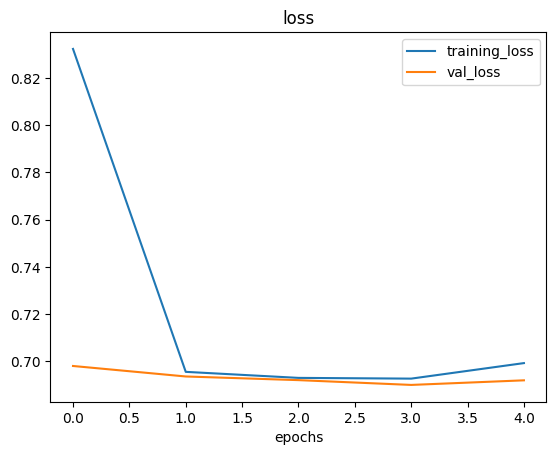

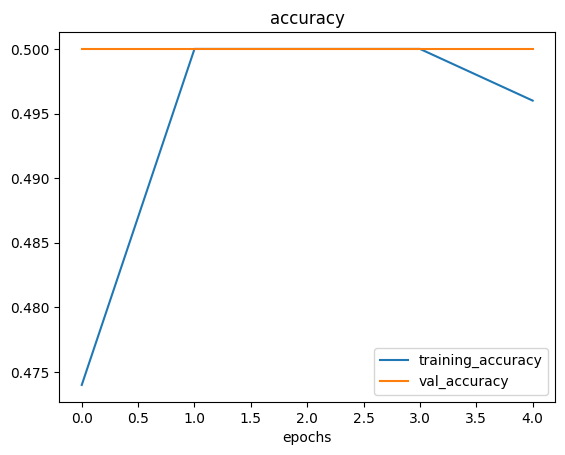

In [ ]:
# Check our models training curves
plot_loss_curve(history_6)

## Let's shuffle the augmented data to compare with model_6

In [ ]:
# Import data and augment it and shuffle from training directory
train_data_augemented_shuffled = train_datagen_augmented.flow_from_directory(train_dir,
                                                                             target_size=(224, 224),
                                                                             class_mode="binary",
                                                                             batch_size=32,
                                                                             shuffle=True)

Found 1500 images belonging to 2 classes.


In [ ]:
# Create a model same as model_5 and model_6
model_7 = Sequential([
    Conv2D(10, 3, activation="relu", input_shape=(224, 224, 3)),
    MaxPool2D(pool_size=2),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation="sigmoid")
])

# Compile the model
model_7.compile(loss="binary_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])

# Fit the model
history_7 = model_7.fit(train_data_augemented_shuffled,
                        epochs=5,
                        steps_per_epoch=len(train_data_augemented_shuffled),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 22s 421ms/step - loss: 0.6479 - accuracy: 0.6187 - val_loss: 0.5444 - val_accuracy: 0.7160
Epoch 2/5
47/47 [==============================] - 29s 620ms/step - loss: 0.5525 - accuracy: 0.7153 - val_loss: 0.4229 - val_accuracy: 0.8020
Epoch 3/5
47/47 [==============================] - 21s 445ms/step - loss: 0.5007 - accuracy: 0.7613 - val_loss: 0.3742 - val_accuracy: 0.8360
Epoch 4/5
47/47 [==============================] - 20s 427ms/step - loss: 0.5010 - accuracy: 0.7513 - val_loss: 0.3769 - val_accuracy: 0.8360
Epoch 5/5
47/47 [==============================] - 23s 487ms/step - loss: 0.4705 - accuracy: 0.7833 - val_loss: 0.3707 - val_accuracy: 0.8500


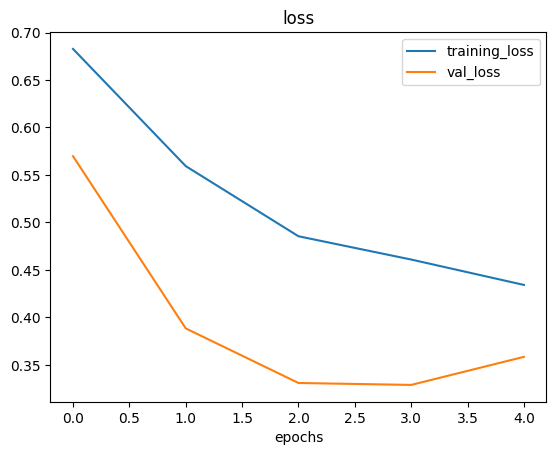

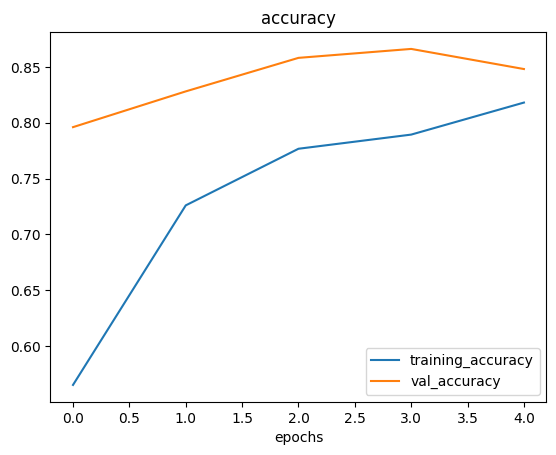

In [ ]:
# Plot loss curves
plot_loss_curve(history_7)

### 7. Repeat until satisfied

 Since we've already beaten our baseline, there are a few things we could try to improve our model:

 * increase the number of layers
 * increase the number of filters
 * Train for longer
 * Find and ideal learning rate
 * get more data to allow model more oportunities to learn
 * use transfer leaning to leverage what antoher model has learned



In [ ]:
# Let's try and improve our model (in this instance we will increase a number of hidden layers)
model_8 = Sequential([
    Conv2D(20, 3, activation="relu", input_shape=(224, 224, 3)),
    MaxPool2D(pool_size=2),
    Conv2D(20, 3, activation="relu"),
    MaxPool2D(),
    Conv2D(20, 3, activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation="sigmoid")
])

# Compile the model
model_8.compile(loss="binary_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])

# Fit the model
history_8 = model_8.fit(train_data_augemented_shuffled,
                        epochs=5,
                        steps_per_epoch=len(train_data_augemented_shuffled),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 25s 476ms/step - loss: 0.6919 - accuracy: 0.5527 - val_loss: 0.6533 - val_accuracy: 0.5280
Epoch 2/5
47/47 [==============================] - 21s 457ms/step - loss: 0.6044 - accuracy: 0.6593 - val_loss: 0.4592 - val_accuracy: 0.7680
Epoch 3/5
47/47 [==============================] - 22s 465ms/step - loss: 0.5179 - accuracy: 0.7453 - val_loss: 0.3643 - val_accuracy: 0.8480
Epoch 4/5
47/47 [==============================] - 21s 440ms/step - loss: 0.4932 - accuracy: 0.7647 - val_loss: 0.3671 - val_accuracy: 0.8360
Epoch 5/5
47/47 [==============================] - 24s 507ms/step - loss: 0.4787 - accuracy: 0.7707 - val_loss: 0.3319 - val_accuracy: 0.8720


In [ ]:
# Let's try updating a learning rate from 0.001 to 0.005 and see how it affects the model
model_9 = Sequential([
    Conv2D(20, 3, activation="relu", input_shape=(224, 224, 3)),
    MaxPool2D(pool_size=2),
    Conv2D(20, 3, activation="relu"),
    MaxPool2D(),
    Conv2D(20, 3, activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation="sigmoid")
])

# Compile the model
model_9.compile(loss="binary_crossentropy",
                optimizer=Adam(learning_rate=0.005),
                metrics=["accuracy"])

# Fit the model
history_9 = model_9.fit(train_data_augemented_shuffled,
                        epochs=5,
                        steps_per_epoch=len(train_data_augemented_shuffled),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 22s 428ms/step - loss: 0.6976 - accuracy: 0.5040 - val_loss: 0.6845 - val_accuracy: 0.6740
Epoch 2/5
47/47 [==============================] - 21s 455ms/step - loss: 0.6503 - accuracy: 0.6580 - val_loss: 0.5264 - val_accuracy: 0.7580
Epoch 3/5
47/47 [==============================] - 21s 456ms/step - loss: 0.6012 - accuracy: 0.6867 - val_loss: 0.5749 - val_accuracy: 0.7400
Epoch 4/5
47/47 [==============================] - 22s 461ms/step - loss: 0.5746 - accuracy: 0.7093 - val_loss: 0.4938 - val_accuracy: 0.7920
Epoch 5/5
47/47 [==============================] - 21s 458ms/step - loss: 0.5708 - accuracy: 0.7173 - val_loss: 0.4601 - val_accuracy: 0.8080


In [ ]:
# Looks like learning rate increase did not help, let's try increase the hidden layers
model_10 = Sequential([
    Conv2D(32, 3, activation="relu", input_shape=(224, 224, 3)),
    MaxPool2D(pool_size=2),
    Conv2D(32, 3, activation="relu"),
    MaxPool2D(),
    Conv2D(32, 3, activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation="sigmoid")
])

# Compile the model
model_10.compile(loss="binary_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])

# Fit the model
history_10 = model_10.fit(train_data_augemented_shuffled,
                        epochs=5,
                        steps_per_epoch=len(train_data_augemented_shuffled),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 25s 464ms/step - loss: 0.6503 - accuracy: 0.6220 - val_loss: 0.5563 - val_accuracy: 0.6940
Epoch 2/5
47/47 [==============================] - 22s 473ms/step - loss: 0.5721 - accuracy: 0.7087 - val_loss: 0.4455 - val_accuracy: 0.7880
Epoch 3/5
47/47 [==============================] - 20s 434ms/step - loss: 0.5142 - accuracy: 0.7533 - val_loss: 0.4016 - val_accuracy: 0.8320
Epoch 4/5
47/47 [==============================] - 22s 460ms/step - loss: 0.4922 - accuracy: 0.7700 - val_loss: 0.3545 - val_accuracy: 0.8520
Epoch 5/5
47/47 [==============================] - 22s 462ms/step - loss: 0.4883 - accuracy: 0.7653 - val_loss: 0.3818 - val_accuracy: 0.8300


In [ ]:
# Looks like increase hidden layers from 20 to 32 did not improve our accuracy. Let's try using model 8 but adding extra epochs
model_11 = Sequential([
    Conv2D(20, 3, activation="relu", input_shape=(224, 224, 3)),
    MaxPool2D(pool_size=2),
    Conv2D(20, 3, activation="relu"),
    MaxPool2D(),
    Conv2D(20, 3, activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation="sigmoid")
])

# Compile the model
model_11.compile(loss="binary_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])

# Fit the model
history_11 = model_11.fit(train_data_augemented_shuffled,
                        epochs=10,
                        steps_per_epoch=len(train_data_augemented_shuffled),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/10
47/47 [==============================] - 23s 464ms/step - loss: 0.6867 - accuracy: 0.5720 - val_loss: 0.5960 - val_accuracy: 0.6940
Epoch 2/10
47/47 [==============================] - 20s 433ms/step - loss: 0.5569 - accuracy: 0.7160 - val_loss: 0.4759 - val_accuracy: 0.7740
Epoch 3/10
47/47 [==============================] - 21s 455ms/step - loss: 0.5353 - accuracy: 0.7247 - val_loss: 0.3879 - val_accuracy: 0.8220
Epoch 4/10
47/47 [==============================] - 20s 430ms/step - loss: 0.4793 - accuracy: 0.7867 - val_loss: 0.3996 - val_accuracy: 0.8480
Epoch 5/10
47/47 [==============================] - 23s 499ms/step - loss: 0.4672 - accuracy: 0.7893 - val_loss: 0.3195 - val_accuracy: 0.8500
Epoch 6/10
47/47 [==============================] - 21s 454ms/step - loss: 0.4633 - accuracy: 0.7947 - val_loss: 0.3107 - val_accuracy: 0.8780
Epoch 7/10
47/47 [==============================] - 20s 430ms/step - loss: 0.4461 - accuracy: 0.7960 - val_loss: 0.2948 - val_accuracy: 0.8760

In [ ]:
# Looks like accuracy kept increasing, so let's try unsing 20 epochs if we can achieve higher accuracy
model_12 = Sequential([
    Conv2D(20, 3, activation="relu", input_shape=(224, 224, 3)),
    MaxPool2D(pool_size=2),
    Conv2D(20, 3, activation="relu"),
    MaxPool2D(),
    Conv2D(20, 3, activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation="sigmoid")
])

# Compile the model
model_12.compile(loss="binary_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])

# Fit the model
history_12 = model_12.fit(train_data_augemented_shuffled,
                        epochs=20,
                        steps_per_epoch=len(train_data_augemented_shuffled),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/20
47/47 [==============================] - 22s 429ms/step - loss: 0.6545 - accuracy: 0.6233 - val_loss: 0.5562 - val_accuracy: 0.6840
Epoch 2/20
47/47 [==============================] - 22s 460ms/step - loss: 0.5353 - accuracy: 0.7313 - val_loss: 0.3591 - val_accuracy: 0.8560
Epoch 3/20
47/47 [==============================] - 22s 465ms/step - loss: 0.4836 - accuracy: 0.7727 - val_loss: 0.3901 - val_accuracy: 0.8360
Epoch 4/20
47/47 [==============================] - 20s 427ms/step - loss: 0.4759 - accuracy: 0.7827 - val_loss: 0.3722 - val_accuracy: 0.8260
Epoch 5/20
47/47 [==============================] - 22s 459ms/step - loss: 0.4664 - accuracy: 0.7887 - val_loss: 0.3219 - val_accuracy: 0.8560
Epoch 6/20
47/47 [==============================] - 22s 462ms/step - loss: 0.4683 - accuracy: 0.7933 - val_loss: 0.3158 - val_accuracy: 0.8640
Epoch 7/20
47/47 [==============================] - 20s 430ms/step - loss: 0.4409 - accuracy: 0.7980 - val_loss: 0.3412 - val_accuracy: 0.8460

## Making a prediction with our trained model on our own custom data

In [ ]:
# classes we're working on
print(class_names)

['pizza' 'steak']


--2024-06-20 08:49:55--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1978213 (1.9M) [image/jpeg]
Saving to: ‘03-steak.jpeg.3’

03-steak.jpeg.3     100%[===================>]   1.89M  --.-KB/s    in 0.04s   

2024-06-20 08:49:55 (49.4 MB/s) - ‘03-steak.jpeg.3’ saved [1978213/1978213]



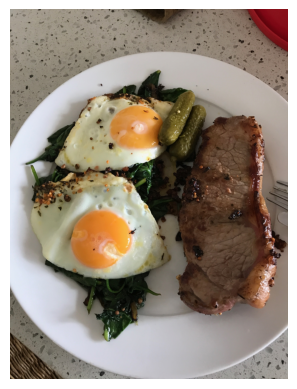

In [ ]:
# View our example image
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
steak = mpimg.imread("03-steak.jpeg")
plt.imshow(steak)
plt.axis(False);

In [ ]:
# Check the shape of our steak image
steak.shape

(4032, 3024, 3)

In [ ]:
# Create a function to import the image and resize to be able to be used for our model
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor and reshapes it to (img_shape, img_shape, colour_channels)
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode the read file into a tensor
  img = tf.image.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, size=[img_shape, img_shape])
  # Rescale the image (get all values between 0 & 1)
  img = img/255.
  return img

In [ ]:
# Load in an preprocess the image
steak = load_and_prep_image("03-steak.jpeg")
steak

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.6377451 , 0.6220588 , 0.57892156],
        [0.6504902 , 0.63186276, 0.5897059 ],
        [0.63186276, 0.60833335, 0.5612745 ],
        ...,
        [0.52156866, 0.05098039, 0.09019608],
        [0.49509802, 0.04215686, 0.07058824],
        [0.52843136, 0.07745098, 0.10490196]],

       [[0.6617647 , 0.6460784 , 0.6107843 ],
        [0.6387255 , 0.6230392 , 0.57598037],
        [0.65588236, 0.63235295, 0.5852941 ],
        ...,
        [0.5352941 , 0.06862745, 0.09215686],
        [0.529902  , 0.05931373, 0.09460784],
        [0.5142157 , 0.05539216, 0.08676471]],

       [[0.6519608 , 0.6362745 , 0.5892157 ],
        [0.6392157 , 0.6137255 , 0.56764704],
        [0.65637255, 0.6269608 , 0.5828431 ],
        ...,
        [0.53137255, 0.06470589, 0.08039216],
        [0.527451  , 0.06862745, 0.1       ],
        [0.52254903, 0.05196078, 0.0872549 ]],

       ...,

       [[0.49313724, 0.42745098, 0.31029412],
        [0.05

In [ ]:
# let's do a prediction on our model_7 using steak image
model_7.predict(tf.expand_dims(steak, axis=0))

1/1 [==============================] - 0s 307ms/step


array([[0.90841085]], dtype=float32)

In [ ]:
# Remind ourselves the class names
class_names

array(['pizza', 'steak'], dtype='<U5')

In [ ]:
# Let's create prediction value
pred = model_7.predict(tf.expand_dims(steak, axis=0))

1/1 [==============================] - 0s 19ms/step


In [ ]:
# We can index the predicted class by rounding the prediction probability and inxing it on class names
pred_class = class_names[int(tf.round(pred))]
pred_class

'steak'

In [ ]:
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  pred_class = class_names[int(tf.round(pred)[0][0])]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

1/1 [==============================] - 0s 30ms/step


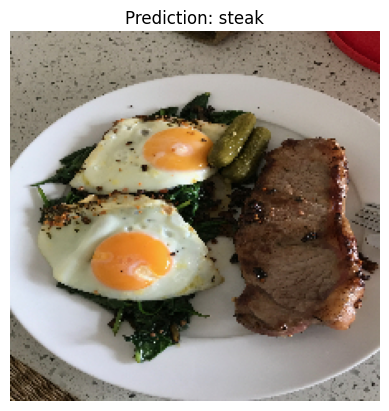

In [ ]:
# Test our model
pred_and_plot(model_7, "03-steak.jpeg")

--2024-06-20 09:51:26--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874848 (2.7M) [image/jpeg]
Saving to: ‘03-pizza-dad.jpeg.4’

03-pizza-dad.jpeg.4 100%[===================>]   2.74M  --.-KB/s    in 0.04s   

2024-06-20 09:51:26 (64.5 MB/s) - ‘03-pizza-dad.jpeg.4’ saved [2874848/2874848]

1/1 [==============================] - 0s 19ms/step


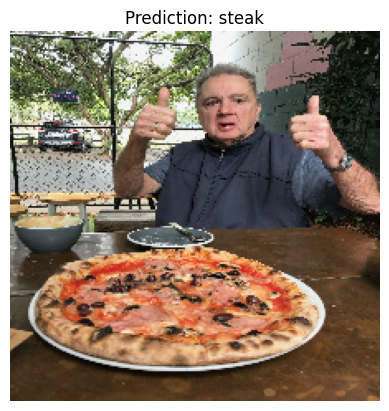

In [ ]:
# Download another test image and make a prediction on it
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
pred_and_plot(model_7, "03-pizza-dad.jpeg", class_names)

## Multi-Class image classification